In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import os
import sys

In [4]:
import jax
from housemaze import maze
from housemaze import utils
from housemaze import renderer
from housemaze.human_dyna import utils as dyna_utils
from housemaze.human_dyna import mazes

from functools import partial
from housemaze.human_dyna import experiments as housemaze_experiments
import os.path
import matplotlib.pyplot as plt
import numpy as np

In [5]:
image_dict = utils.load_image_dict()

No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl


In [6]:
char2key, task_group_set, task_objects = mazes.get_group_set(3)
char2key

No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


{'A': np.int32(26),
 'B': np.int32(40),
 'C': np.int32(47),
 'D': np.int32(43),
 'E': np.int32(25),
 'F': np.int32(30),
 'G': np.int32(29),
 'H': np.int32(27)}

((224, 256, 3),
 ['empty', 'wall', 'apple_sliced', 'spoon', 'onion_sliced_cooked'])

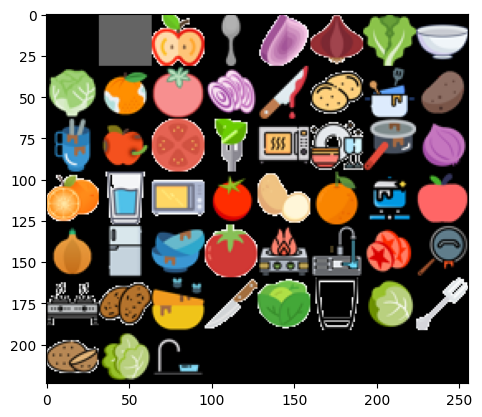

In [7]:
image = renderer.create_image_grid_from_image_tensor(image_dict['images'], max_cols=8)
plt.imshow(image)

image.shape, image_dict['keys'][:5]

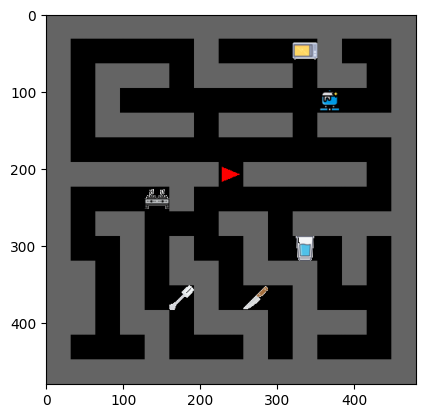

In [8]:
def render_maze(maze_str):
    level_init = utils.from_str(maze_str, char2key)
    image = renderer.create_image_from_grid(*level_init, image_dict)
    plt.imshow(image)
    plt.show()

def render_path(maze_str, goal):
    level_init = utils.from_str(maze_str, char2key)
    image = renderer.create_image_from_grid(*level_init, image_dict)
    path = utils.find_optimal_path(level_init[0], level_init[1], np.array([goal]))
    print(f"Path length: {len(path)}")
    actions = utils.actions_from_path(path)
    renderer.place_arrows_on_image(image, path, actions, *level_init[0].shape[:2])
    plt.show()

render_maze(mazes.maze0)
# render_maze(mazes.maze1)
# render_maze(mazes.maze2)
# render_maze(mazes.maze3)
# render_maze(mazes.maze4)

# Manipulation 1: Maze 3 Shortcut

Path length: 35


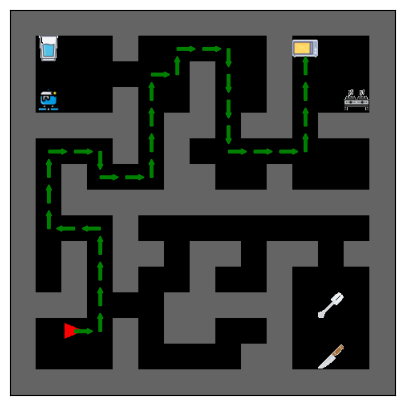

Path length: 35


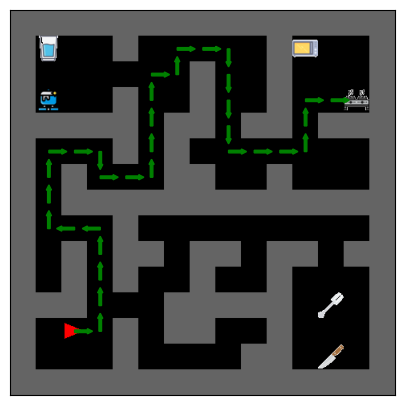

Path length: 21


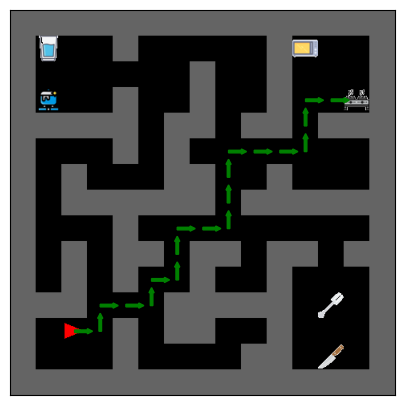

Path length: 29


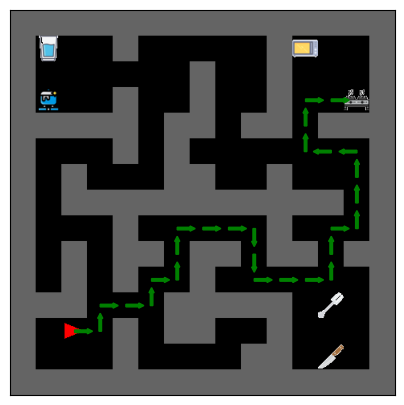

In [19]:
maze3_open = """
E..#.....#A..
......#..#...
F..#..#..#..B
##.#.##.##.##
...#.#.......
.#...##..#...
.###########.
...#......#..
.#.##.##.##.#
.#.#.....#...
##...###.#.C.
.>.#.##......
...#....##.D.
""".strip()

maze3_open2 = """
E..#.....#A..
......#..#...
F..#..#..#..B
####.##.##.##
...#.#.......
.#...##..#...
.###########.
...#.....#...
.#.##.##.##.#
.#.#..#......
##...#####.C.
.>.#.##..#...
...#....##.D.
""".strip()

render_path(mazes.maze3, goal=task_objects[0])

# render_path(mazes.maze3, goal=task_objects[2])

# render_path(mazes.maze3, goal=task_objects[4])

render_path(mazes.maze3, goal=task_objects[1])
render_path(mazes.maze3_open, goal=task_objects[1])
render_path(mazes.maze3_open2, goal=task_objects[1])

# Manipulation 2: Faster when on-path but further than off-path but closer

Path length: 35


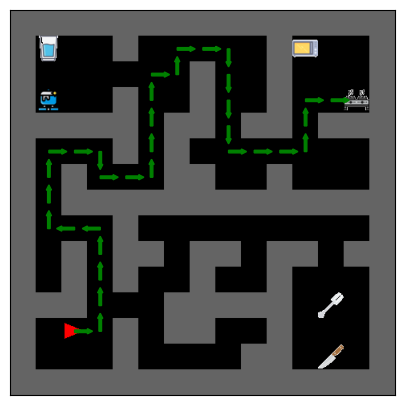

Path length: 27


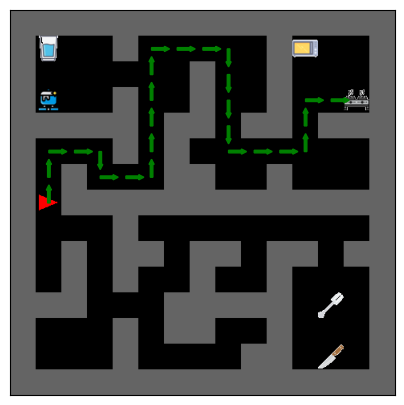

Path length: 27


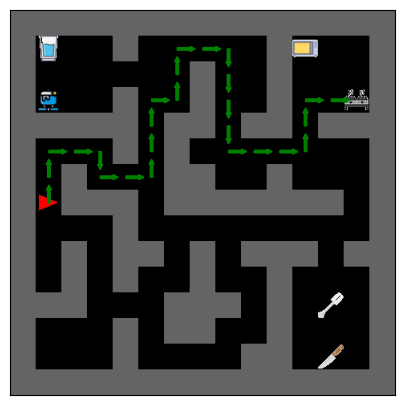

Path length: 23


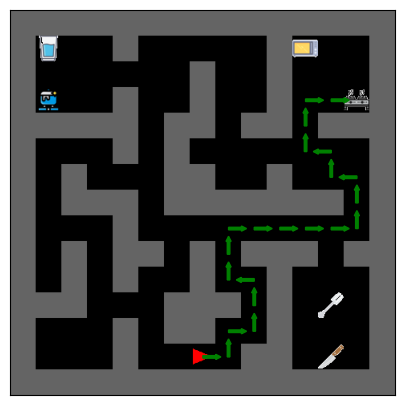

In [10]:
maze3_onpath = """
E..#.....#A..
......#..#...
F..#..#..#..B
####.##.##.##
...#.#.......
.#...##..#...
>############
...#.........
.#.##.##.##.#
.#.#..#..#...
##...#####.C.
...#.##..#...
...#....##.D.
""".strip()

render_path(mazes.maze3, goal=task_objects[1])
render_path(maze3_onpath, goal=task_objects[1])

maze3_onpath_shortcut = """
E..#.....#A..
......#..#...
F..#..#..#..B
####.##.##.##
...#.#.......
.#...##..#...
>###.#######.
...#.........
.#.##.#.###.#
.#.#..#..#...
##...###.#.C.
...#.##..#...
...#....##.D.
""".strip()
render_path(maze3_onpath_shortcut, goal=task_objects[1])

maze3_offpath_shortcut = """
E..#.....#A..
......#..#...
F..#..#..#..B
####.##.##.##
...#.#.......
.#...##..#...
.###.#######.
...#.........
.#.##.#.###.#
.#.#..#..#...
##...###.#.C.
...#.##..#...
...#..>.##.D.
""".strip()
render_path(maze3_offpath_shortcut, goal=task_objects[1])

# Manipulation 3: Reusing longer of two paths if training path

Path length: 30


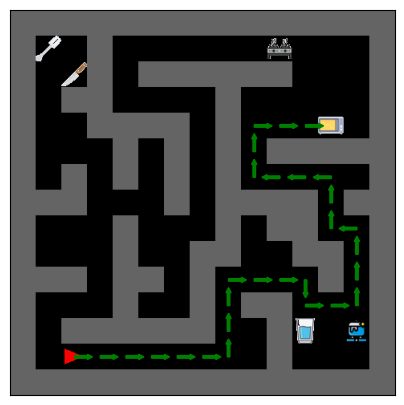

Path length: 31


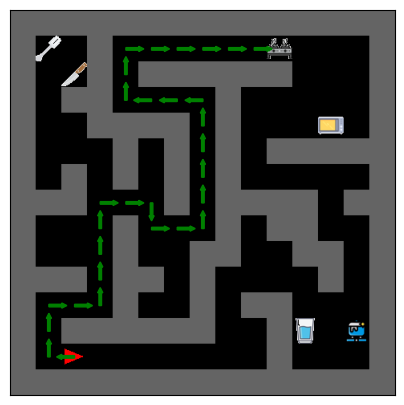

In [11]:
maze5 = """
C.#......B...
.D#.######...
.##....#.....
..####.#.....
...#.#.#.###A
.#.#.#.#...#.
##...#.###.##
...#...#.#...
...#..##.###.
##.##.#....#.
...#..#.##...
.######..#E.F
.>.......#...
""".strip()

maze5 = mazes.maze5

render_path(maze5, goal=task_objects[0])
render_path(maze5, goal=task_objects[1])


# # offtask = task_objects[1]


# Manipulation 4: probing for planning near goal

Original map
Path length: 39


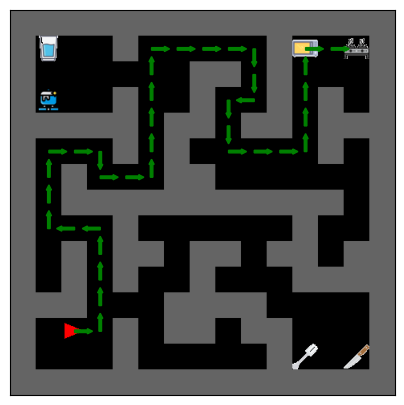

Path length: 39


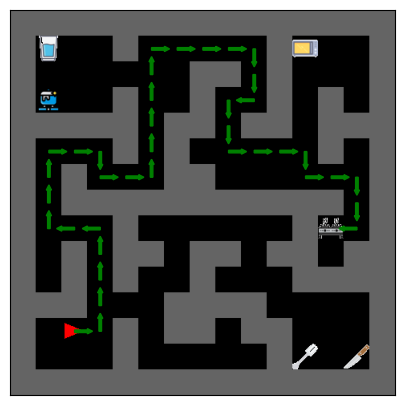

train
Path length: 37


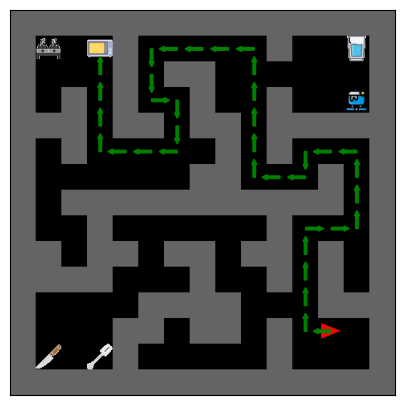

test 1
Path length: 39


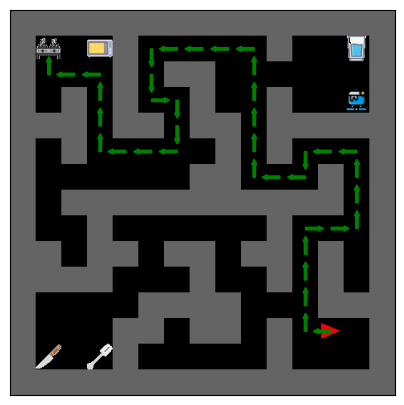

test 2
Path length: 39


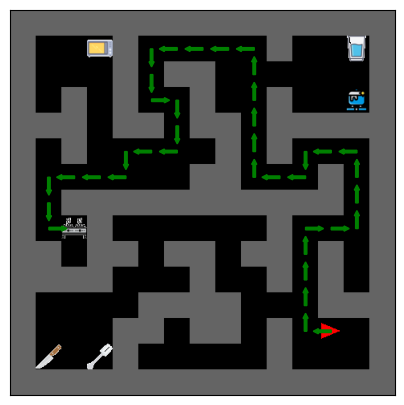

In [16]:
rev = partial(mazes.reverse, horizontal=True, vertical=False)


maze6 = """
E..#.....#A.B
......##.#...
F..#..#..#.#.
####.##.##.##
...#.#.....#.
.#...##......
.###########.
...#......#..
.#.##.##.##.#
.#.#..#...###
##...####....
.>.#.##.##...
...#.....#C.D
""".strip()

maze6_flipped_offtask = """
E..#.....#A..
......##.#...
F..#..#..#.#.
####.##.##.##
...#.#.....#.
.#...##......
.###########.
...#......#B.
.#.##.##.##.#
.#.#..#...###
##...####....
.>.#.##.##...
...#.....#C.D
""".strip()



print("Original map")
render_path(maze6, goal=task_objects[1])
render_path(maze6_flipped_offtask, goal=task_objects[1])

print("train")
render_path(rev(maze6), goal=task_objects[0])
print("test 1")
render_path(rev(maze6), goal=task_objects[1])
print("test 2")
render_path(rev(maze6_flipped_offtask), goal=task_objects[1])


# # # offtask = task_objects[1]
